In [1]:
import scvelo as scv 
import scanpy as sc
import numpy as np
import pandas as pd

In [2]:
def extract_paga_transitions(adata, key):
    clusters = adata.obs[key].cat.categories
    paga = np.array(adata.uns['paga']['transitions_confidence'].todense())
    paga_con = np.array(adata.uns['paga']['connectivities'].todense())
    transitions = []
    connectivities = []
    confidence = []
    for i in range(clusters.shape[0]):
        for j in range(clusters.shape[0]):
            if paga[i,j] > 0:
                transition = clusters[j] + '->' + clusters[i]
                transitions.append(transition)
                confidence.append(paga[i,j])
                connectivities.append(paga_con[i,j])
                
    return pd.DataFrame({'transition': transitions, 'confidence': confidence,
                        'connectivity': connectivities})

In [3]:
adata = sc.read('../../../../../../../media/spencer/Extra HDD/fits/latentvelo_C2.h5ad')

In [4]:
import pandas as pd
meta = pd.read_csv('../../../../../../../media/spencer/Seagate Backup Plus Drive/scRNAseq/lung/raw_c2/c2_metadata_Aug19.csv',
                  index_col=0)

umap = pd.read_csv('../../../../../../../media/spencer/Seagate Backup Plus Drive/scRNAseq/lung/raw_c2/c2_Embeddings.csv',
                  index_col=0)



adata.obs['id'] = [str(x.split('-')[0]) +'-'+ str(x.split('-')[1]) for x in adata.obs.index.values]
adata.obs = adata.obs.set_index('id')


import numpy as np
adata.obs['cell_type'] = meta['cell_type']
adata.obs['cell_type_num'] = meta['cell_type_Aug']
adata.obs['sample_week'] = meta['sample_week']
adata.obs['UMAP1'] = umap['UMAP_1']
adata.obs['UMAP2'] = umap['UMAP_2']
adata.obsm['X_umap'] = np.array([adata.obs.UMAP1, adata.obs.UMAP2]).T

In [5]:
adata.obs['cell_type'] = adata.obs['cell_type'].astype('category')
adata.obs['cell_type_num'] = adata.obs['cell_type_num'].astype('category')

adata.obs['cell_type'] = adata.obs['cell_type'].cat.rename_categories({'SOX2+CFTR+ 2 cells': 'SOX2highCFTR+ cells',
                                                                      'SOX2+CFTR+ 1 cells': 'SOX2lowCFTR+ cells',
                                                                      'Early AT2-like cells': 'Tip cells'})

adata.obs['cell_type_num'] = adata.obs['cell_type_num'].cat.rename_categories({'Early AT2-like cells (4)': 'Tip cells (4)'})

adata.obs['cell_type'] = adata.obs['cell_type'].astype('category')
adata.obs['cell_type_num'] = adata.obs['cell_type_num'].astype('category')

adata.obs['sample_week'] = meta['sample_week']

In [6]:
epi_palette =  {'Basal cells':'#1f77b4', 'Budtip progenitors':'#ff7f0e', 'Ciliated precursor cells':'#2ca02c', 'Club cells':'#d62728', 'Tip cells':'#9467bd', 'Mature ciliated cells':'#8c564b', 'NKX2-1+SOX9+CFTR+ cells':'#e377c2', 'NRGN+ cells':'#7f7f7f', 'PNEC':'#bcbd22', 'PTEN+STAT3+ cells':'#17becf', 'Proliferating progenitors':'#aec7e8', 'SCGB3A2+FOXJ1+ cells':'#ffbb78', 'SCGB3A2+SFTPB+CFTR+ cells':'#98df8a', 'SMG basal cells':'#ff9896', 'SMG secretory cells':'#c5b0d5', 'SOX2lowCFTR+ cells': '#f7b6d2', 'SOX2highCFTR+ cells': '#c49c94', 'Stromal-like cells 1':'#c7c7c7', 'Stromal-like cells 2':'#dbdb8d'} 
epi_palette_num = {'Basal cells (19)':'#1f77b4', 'Budtip progenitors (1)':'#ff7f0e', 'Ciliated precursor cells (10)':'#2ca02c', 'Club cells (16)':'#d62728', 'Tip cells (4)':'#9467bd', 'Mature ciliated cells (3)':'#8c564b', 'NKX2-1+SOX9+CFTR+ cells (11)':'#e377c2', 'NRGN+ cells (17)':'#7f7f7f', 'PNEC (12)':'#bcbd22', 'PTEN+STAT3+ cells (8)':'#17becf', 'Proliferating progenitors (5)':'#aec7e8', 'SCGB3A2+FOXJ1+ cells (13)':'#ffbb78', 'SCGB3A2+SFTPB+CFTR+ cells (9)':'#98df8a', 'SMG basal cells (15)':'#ff9896', 'SMG secretory cells (18)':'#c5b0d5', 'SOX2highCFTR+ cells (7)':'#c49c94', 'SOX2lowCFTR+ cells (6)':'#f7b6d2', 'Stromal-like cells 1 (2)':'#c7c7c7', 'Stromal-like cells 2 (14)':'#dbdb8d'}

computing neighbors
    finished (0:01:44) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity graph (using 1/16 cores)


  0%|          | 0/14915 [00:00<?, ?cells/s]

    finished (0:00:05) --> added 
    'spliced_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:02) --> added
    'spliced_velocity_umap', embedded velocity vectors (adata.obsm)


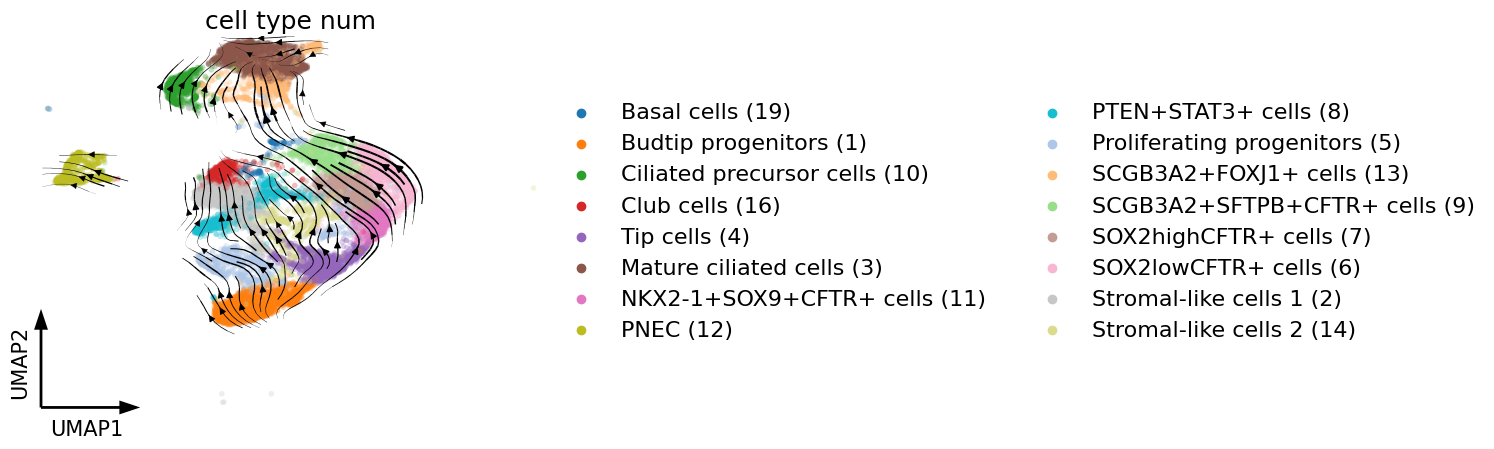

In [7]:
scv.pp.neighbors(adata, use_rep='X', n_neighbors=30)
scv.tl.velocity_graph(adata,vkey='spliced_velocity',
                     sqrt_transform=False)
scv.pl.velocity_embedding_stream(adata, vkey='spliced_velocity', 
                                color=['cell_type_num'], frameon='artist', fontsize=18,
                                cutoff_perc=0, legend_loc='right', legend_fontsize=16,
                                 palette=epi_palette_num,
                                 ncols=1)

In [9]:
scv.tl.velocity_graph(adata, vkey='spliced_velocity')

computing velocity graph (using 1/16 cores)


  0%|          | 0/14915 [00:00<?, ?cells/s]

    finished (0:00:05) --> added 
    'spliced_velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [10]:
scv.tl.paga(adata, vkey='spliced_velocity', 
            use_time_prior='latent_time', groups='cell_type',
           minimum_spanning_tree=False)

running PAGA using priors: ['latent_time']
    finished (0:00:02) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


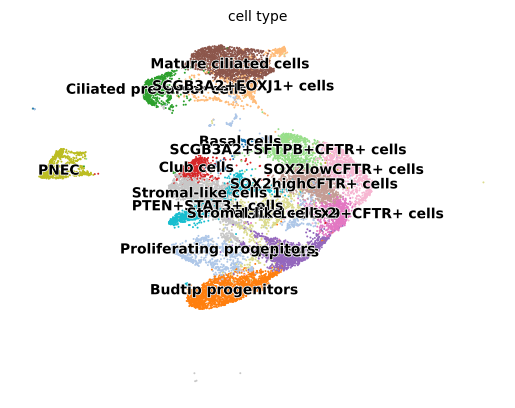

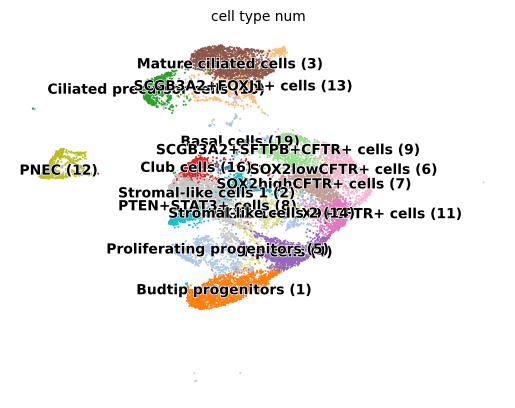

In [11]:
scv.pl.umap(adata, color='cell_type', palette=epi_palette)
scv.pl.umap(adata, color='cell_type_num', palette=epi_palette_num)

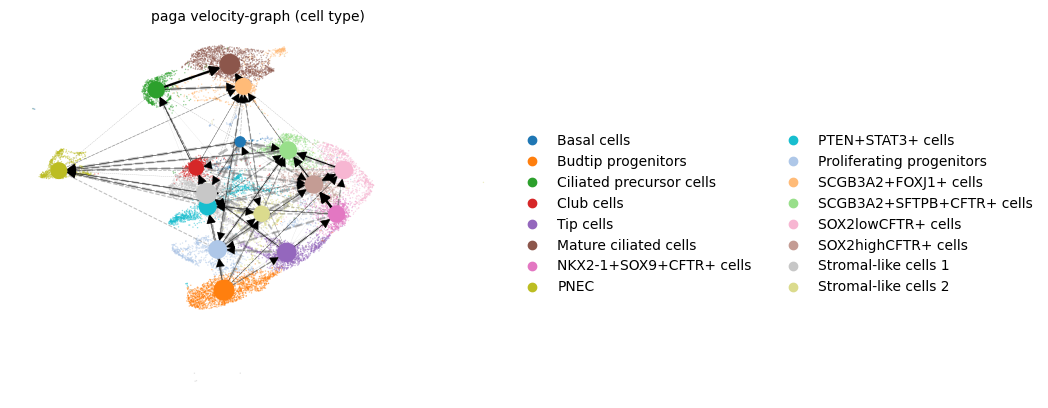

In [12]:
scv.pl.paga(adata, basis='umap')

In [13]:

clusters = adata.obs['cell_type_num'].cat.categories
paga = np.array(adata.uns['paga']['transitions_confidence'].todense())
paga_con = np.array(adata.uns['paga']['connectivities'].todense())
for i in range(clusters.shape[0]):
    for j in range(clusters.shape[0]):
        if paga_con[i,j] < 0.23:
            adata.uns['paga']['transitions_confidence'][i,j] = 0

In [14]:
pos = adata.uns['paga']['pos']
pos[3,0] = -2.1
pos[5,1] = 11.6
pos[8,0] = -3.2
pos[8,1] = -2.3

0 Basal cells (19) 19
1 Budtip progenitors (1) 1
2 Ciliated precursor cells (10) 10
3 Club cells (16) 16
4 Tip cells (4) 4
5 Mature ciliated cells (3) 3
6 NKX2-1+SOX9+CFTR+ cells (11) 11
7 PNEC (12) 12
8 PTEN+STAT3+ cells (8) 8
9 Proliferating progenitors (5) 5
10 SCGB3A2+FOXJ1+ cells (13) 13
11 SCGB3A2+SFTPB+CFTR+ cells (9) 9
12 SOX2highCFTR+ cells (7) 7
13 SOX2lowCFTR+ cells (6) 6
14 Stromal-like cells 1 (2) 2
15 Stromal-like cells 2 (14) 14


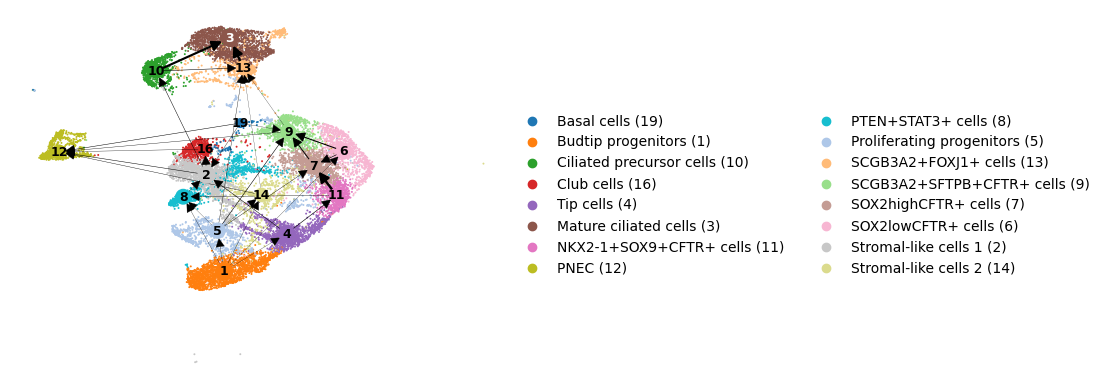

In [15]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots()#figsize=(8,8))
scv.pl.paga(adata, size=50, alpha=.25, pos=pos,#
            edge_scale_width=2,
            min_edge_width=0, node_size_scale=0.75, threshold=0.045,
           dashed_edges = None, ax=ax, show=False,palette =epi_palette)


for i,ct in enumerate(adata.obs.cell_type_num.cat.categories):
    X_emb = np.array(adata[adata.obs['cell_type_num']==ct].obsm['X_umap'])
    x_pos, y_pos = pos[i]# np.median(X_emb, axis=0) #
    label = ct[-4:].split('(')[1].split(')')[0]
    print(i, ct, label)
    if label =='6':
        label='7'
    elif label=='7':
        label='6'
    if label == '3':# or label=='18':
        ax.text(x_pos, y_pos, str(label), zorder=10000, horizontalalignment='center', verticalalignment='center',
               color='white',fontweight='bold',fontsize=9)
    else:
        ax.text(x_pos, y_pos, str(label), zorder=10000, horizontalalignment='center', 
                verticalalignment='center',fontweight='bold',fontsize=9)
scv.pl.umap(adata, color='cell_type_num', ax=ax, legend_loc='right', palette=epi_palette_num,
            title='', save='figures/latentvelo_Epithelial_PAGA.pdf')
plt.show()

In [18]:
pd.DataFrame(adata.uns['paga']['transitions_confidence'].todense(),index=adata.obs.cell_type_num.cat.categories, 
             columns=adata.obs.cell_type_num.cat.categories).to_csv('data/Epithelial_PAGA.csv')

# Early

In [19]:
adata_10 = adata[adata.obs.sample_week.isin(['week_10', 'week_11', 'week_12', 'week_13'])]

In [20]:
counts_10 = adata_10.obs.groupby('cell_type').apply(lambda x: len(x))
for i in range(len(counts_10)):
    print(counts_10.index.values[i], counts_10[i])
    if counts_10[i] < 4:
        adata_10 = adata_10[adata_10.obs.cell_type != counts_10.index.values[i]]

Budtip progenitors 154
Ciliated precursor cells 10
Club cells 143
Tip cells 170
Mature ciliated cells 5
NKX2-1+SOX9+CFTR+ cells 61
PNEC 316
PTEN+STAT3+ cells 201
Proliferating progenitors 233
SCGB3A2+FOXJ1+ cells 4
SCGB3A2+SFTPB+CFTR+ cells 159
SOX2lowCFTR+ cells 222
SOX2highCFTR+ cells 391
Stromal-like cells 1 464
Stromal-like cells 2 62


computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity graph (using 1/16 cores)


  0%|          | 0/2595 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'spliced_velocity_graph', sparse matrix with cosine correlations (adata.uns)
running PAGA using priors: ['latent_time']
    finished (0:00:00) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)
                                           transition  confidence  \
0                       Tip cells->Budtip progenitors    0.021837   
1      SCGB3A2+FOXJ1+ cells->Ciliated precursor cells    0.031623   
2                    Stromal-like cells 1->Club cells    0.150369   
3     Ciliated precursor cells->Mature ciliated cells    0.084853   
4         Budtip progenitors->NKX2-1+SOX9+CFTR+ cells    0.029921   
5                  Tip cells->NKX2-1+SOX9+CFTR+ cells    0.277578   
6                                    Club cells->PNEC    0.089694   
7                     SCGB3A2+SFTPB+CFTR+ cells->PNEC    0

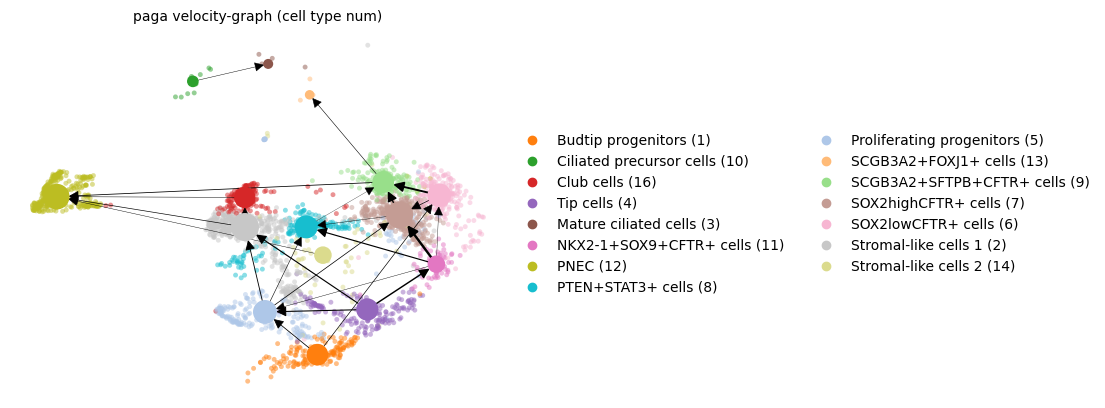

In [21]:
scv.pp.neighbors(adata_10, use_rep='X', n_neighbors=30)
scv.tl.velocity_graph(adata_10, vkey='spliced_velocity')
scv.tl.paga(adata_10, vkey='spliced_velocity', 
            use_time_prior='latent_time', groups='cell_type_num',
           minimum_spanning_tree=False)
print(extract_paga_transitions(adata_10, 'cell_type'))

scv.pl.paga(adata_10, size=50, alpha=.5, basis='umap',dashed_edges = None,
            edge_width_scale=0.5,
            min_edge_width=0, node_size_scale=1.5, threshold=0.045)

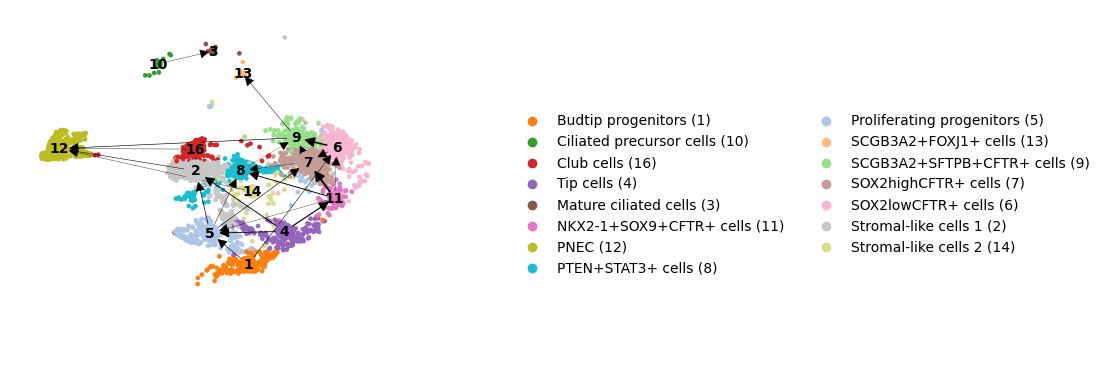

In [22]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots()#figsize=(8,8))
scv.pl.paga(adata_10, size=50, alpha=.25, basis='umap',
            edge_scale_width=2,
            min_edge_width=0, node_size_scale=1, threshold=0.045,
           dashed_edges = None, ax=ax, show=False)


for ct in adata_10.obs.cell_type_num.unique():
    X_emb = np.array(adata_10[adata_10.obs['cell_type_num']==ct].obsm['X_umap'])
    x_pos, y_pos = np.median(X_emb, axis=0)
    label = ct[-4:].split('(')[1].split(')')[0]
    if False:#label == '19' or label == '3':# or label=='18':
        ax.text(x_pos, y_pos, str(label), zorder=10000, horizontalalignment='center', verticalalignment='center',
               color='white',fontweight='bold')
    else:
        ax.text(x_pos, y_pos, str(label), zorder=10000, horizontalalignment='center', 
                verticalalignment='center',fontweight='bold')
scv.pl.umap(adata, color='white', ax=ax, legend_loc='right', title='',
            show=False)
scv.pl.umap(adata_10, color='cell_type_num', ax=ax, legend_loc='right', title='',
            save='figures/latentvelo_Epithelial_PAGA_weeks10to13.pdf')
plt.show()

In [23]:
pd.DataFrame(adata_10.uns['paga']['transitions_confidence'].todense(),
             index=adata_10.obs.cell_type_num.cat.categories, 
             columns=adata_10.obs.cell_type_num.cat.categories).to_csv('data/Epithelial_Early_PAGA.csv')

# Mid

In [24]:
adata_15 = adata[adata.obs.sample_week.isin(['week_15', 'week_14', 'week_16'])]

In [25]:
counts_15 = adata_15.obs.groupby('cell_type').apply(lambda x: len(x))
for i in range(len(counts_10)):
    print(counts_10[i])
    if counts_10[i] < 4:
        adata_10 = adata_10[adata_10.obs.cell_type != counts_10.index.values[i]]

154
10
143
170
5
61
316
201
233
4
159
222
391
464
62


computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity graph (using 1/16 cores)


  0%|          | 0/7071 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'spliced_velocity_graph', sparse matrix with cosine correlations (adata.uns)
running PAGA using priors: ['latent_time']
    finished (0:00:01) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)
                                           transition  confidence  \
0               Basal cells->Ciliated precursor cells    0.057204   
1                Club cells->Ciliated precursor cells    0.065260   
2                      PNEC->Ciliated precursor cells    0.030025   
3      Stromal-like cells 1->Ciliated precursor cells    0.218908   
4      Stromal-like cells 2->Ciliated precursor cells    0.032100   
5                             Basal cells->Club cells    0.038744   
6               SCGB3A2+SFTPB+CFTR+ cells->Club cells    0.032999   
7                    Stromal-like cells 1->Club cells    0

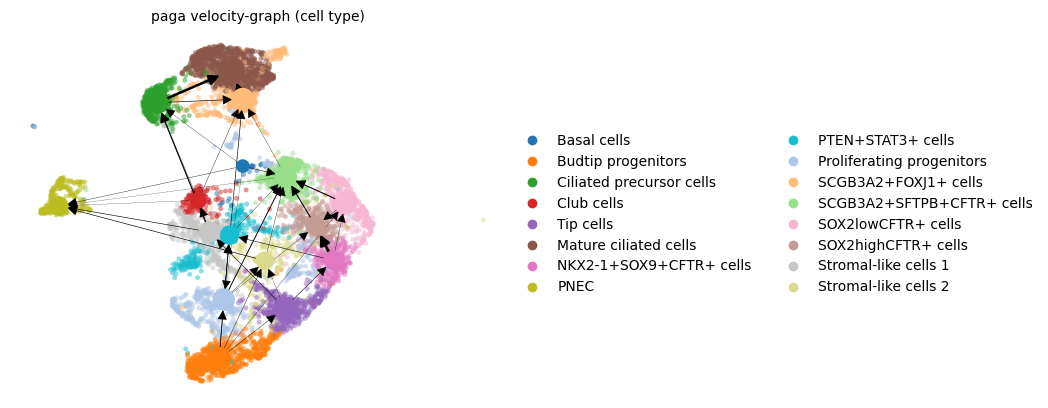

In [26]:
scv.pp.neighbors(adata_15, use_rep='X', n_neighbors=30)
scv.tl.velocity_graph(adata_15, vkey='spliced_velocity')
scv.tl.paga(adata_15, vkey='spliced_velocity', 
            use_time_prior='latent_time', groups='cell_type',
           minimum_spanning_tree=False)
print(extract_paga_transitions(adata_15, key='cell_type'))
confidence_15 = extract_paga_transitions(adata_15, key='cell_type')
scv.pl.paga(adata_15, size=50, alpha=.5, basis='umap',dashed_edges = None,
            edge_width_scale=0.5,
            min_edge_width=0, 
            node_size_scale=1.5, threshold=0.04)

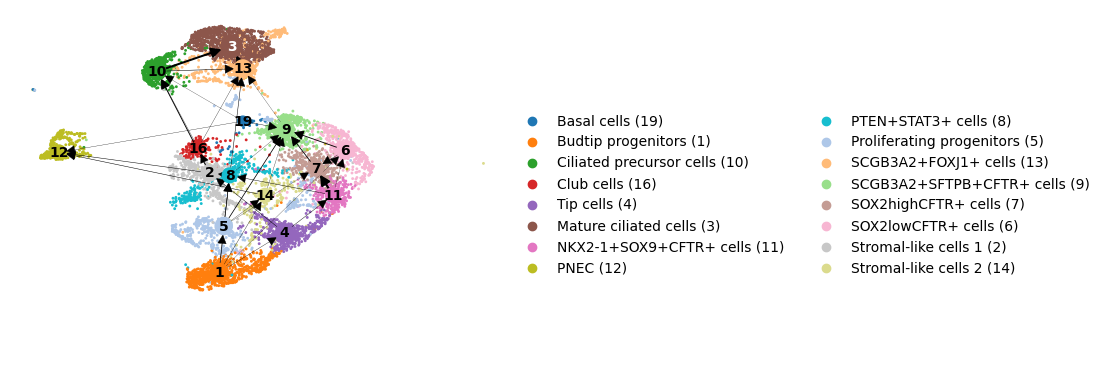

In [28]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots()
scv.pl.paga(adata_15, size=50, alpha=.25, basis='umap',
            edge_scale_width=2,
            min_edge_width=0, node_size_scale=1, threshold=0.045,
           dashed_edges = None, ax=ax, show=False)


for ct in adata_15.obs.cell_type_num.unique():
    X_emb = np.array(adata_15[adata_15.obs['cell_type_num']==ct].obsm['X_umap'])
    x_pos, y_pos = np.median(X_emb, axis=0)
    label = ct[-4:].split('(')[1].split(')')[0]
    if label == '3':# or label=='18':
        ax.text(x_pos, y_pos, str(label), zorder=10000, horizontalalignment='center', verticalalignment='center',
               color='white',fontweight='bold')
    else:
        ax.text(x_pos, y_pos, str(label), zorder=10000, horizontalalignment='center', 
                verticalalignment='center',fontweight='bold')
        
scv.pl.umap(adata, color='white', ax=ax, legend_loc='right', title='',show=False)
        
scv.pl.umap(adata_15, color='cell_type_num', ax=ax, legend_loc='right', title='',
            save='figures/latentvelo_Epithelial_PAGA_weeks14to16.pdf')
plt.show()

In [29]:
pd.DataFrame(adata_15.uns['paga']['transitions_confidence'].todense(),
             index=adata_15.obs.cell_type_num.cat.categories, 
             columns=adata_15.obs.cell_type_num.cat.categories).to_csv('data/Epithelial_Mid_PAGA.csv')

# Late

In [30]:
adata_19 = adata[adata.obs.sample_week.isin(['week_17','week_18','week_19'])]

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity graph (using 1/16 cores)


  0%|          | 0/5249 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'spliced_velocity_graph', sparse matrix with cosine correlations (adata.uns)
running PAGA using priors: ['latent_time']
    finished (0:00:01) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)
                                           transition  confidence  \
0                              Tip cells->Basal cells    0.013560   
1                Club cells->Ciliated precursor cells    0.032425   
2      Stromal-like cells 1->Ciliated precursor cells    0.041584   
3                             Basal cells->Club cells    0.148753   
4               SCGB3A2+SFTPB+CFTR+ cells->Club cells    0.054005   
5                    Stromal-like cells 1->Club cells    0.127708   
6                       Budtip progenitors->Tip cells    0.019680   
7     Ciliated precursor cells->Mature ciliated cells    0

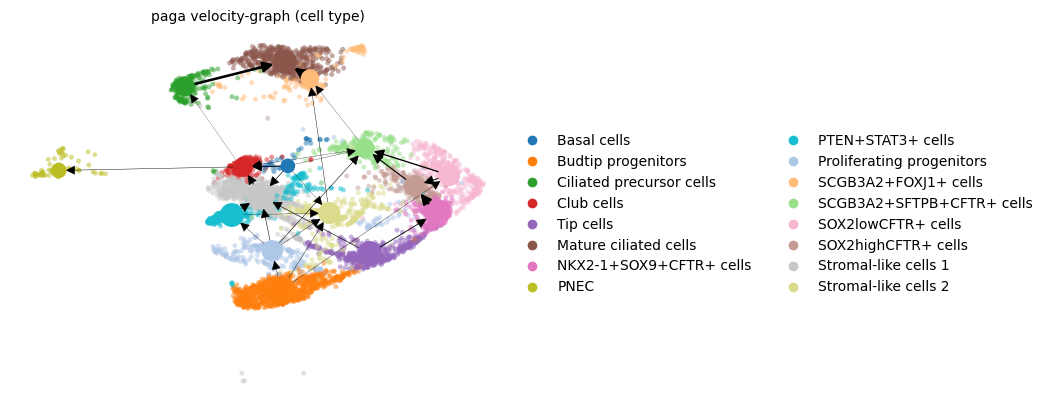

In [31]:

scv.pp.neighbors(adata_19, use_rep='X', n_neighbors=30)
scv.tl.velocity_graph(adata_19, vkey='spliced_velocity')
scv.tl.paga(adata_19, vkey='spliced_velocity', 
            use_time_prior='latent_time', groups='cell_type',
           minimum_spanning_tree=False)
print(extract_paga_transitions(adata_19, 'cell_type'))

scv.pl.paga(adata_19, size=50, alpha=.5, basis='umap',dashed_edges = None,
            edge_width_scale=0.5,
            min_edge_width=0, node_size_scale=1.5, threshold=0.04)

In [32]:
pos = adata_19.uns['paga']['pos']
#pos[3,0] = -2.2
#pos[3,1] = 2.3
pos[0] = np.array([-0.32841332,  4.14352412])

0 19
1 1
2 10
3 16
4 4
5 3
6 11
7 12
8 8
9 5
10 13
11 9
12 7
13 6
14 2
15 14


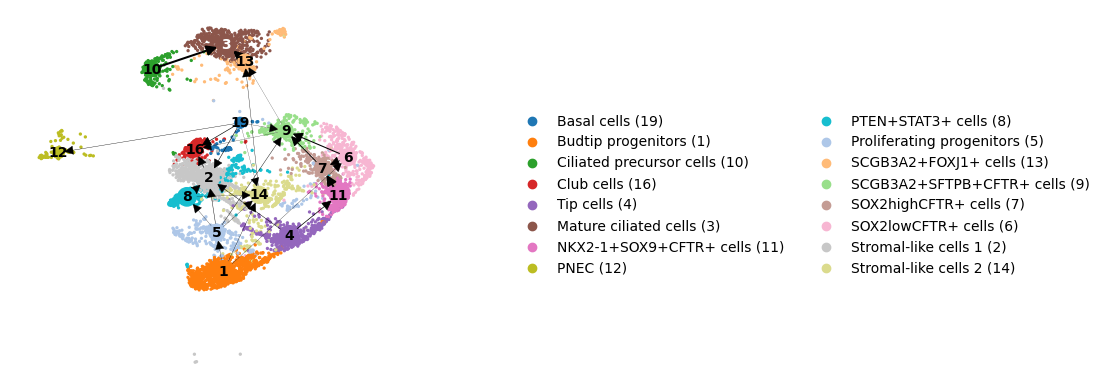

In [33]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots()#figsize=(8,8))
scv.pl.paga(adata_19, size=50, alpha=.25, pos=pos,
            edge_scale_width=2,
            min_edge_width=0, node_size_scale=1, threshold=0.045,
           dashed_edges = None, ax=ax, show=False)


for i,ct in enumerate(adata_19.obs.cell_type_num.cat.categories):
    X_emb = np.array(adata_19[adata_19.obs['cell_type_num']==ct].obsm['X_umap'])
    x_pos, y_pos = pos[i]#np.median(X_emb, axis=0)
    label = ct[-4:].split('(')[1].split(')')[0]
    print(i, label)
    if label =='6':
        label='7'
    elif label=='7':
        label='6'
    if label == '3':# or label=='18':
        ax.text(x_pos, y_pos, str(label), zorder=10000, horizontalalignment='center', verticalalignment='center',
               color='white',fontweight='bold')
    else:
        ax.text(x_pos, y_pos, str(label), zorder=10000, horizontalalignment='center', 
                verticalalignment='center',fontweight='bold')
scv.pl.umap(adata, color='white', ax=ax, legend_loc='right', title='', show=False)
scv.pl.umap(adata_19, color='cell_type_num', ax=ax, legend_loc='right', title='',
            save='figures/latentvelo_Epithelial_PAGA_weeks17to19.pdf')

plt.show()

In [34]:
pd.DataFrame(adata_19.uns['paga']['transitions_confidence'].todense(),
             index=adata_19.obs.cell_type_num.cat.categories, 
             columns=adata_19.obs.cell_type_num.cat.categories).to_csv('data/Epithelial_Late_PAGA.csv')